In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from utils import (
    detrend, monthly_anomalies, corr_with_ttest
)

In [2]:
eq = dict(lat=0,lon=slice(140,260))
time = slice('1958-01','2019-11')

In [3]:
t_grid_file = xr.open_zarr('data/ORCA025.L46-KFS006_TroPA.zarr')

### Nemo SSH 

In [4]:
ssh_nemo = monthly_anomalies(t_grid_file.sossheig.sel(**eq)).compute()

### D20 from Nemo 

In [5]:
d20_nemo = monthly_anomalies(
    t_grid_file.d20.sel(**eq)
).fillna(0.).compute()

### SSH from linear model 

In [6]:
eta = (
    xr.open_zarr("data/lmmm_eta_nemo.zarr/")
    .eta
    .interp(lat=0.).sel(lon=eq["lon"])
)

In [7]:
eta_a = eta.assign_coords(
    {'time':(eta.time-np.timedelta64(1314900,'s')).data}
).interp(time=ssh_nemo.time).fillna(0.).compute()

In [8]:
def fitting(ssha,eta_x):
    mask = ~(
        np.isnan(ssha).all('time')
        | np.isnan(eta_x.sel(mode=1)).all('time')
    )
    a = np.vstack(
        [
            eta_x.sel(mode=k)[:, mask].values.flatten()
            for k in (1,2,3)
        ]
    ).T
    a_inv = np.linalg.pinv(a)

    b = ssha[:, mask].values.flatten()

    coeff = a_inv.dot(b)
    coeff = xr.DataArray(
        coeff,
        coords=(eta_x.sel(mode=slice(1, 3)).mode,),
        dims=("mode",)
    )
    return coeff

In [9]:
coeff = fitting(ssh_nemo,eta_a)

In [10]:
ssh_lin = (coeff * eta_a).sum("mode")

### 2. Fig6a: Correlation

In [11]:
dseta = xr.Dataset({"sshne": ssh_nemo, "sshli": ssh_lin, "d20ne": d20_nemo})
dseta_dt = detrend(dseta.compute())

In [12]:
corr_ssha_sshlia, corr_ssha_sshlia_low, corr_ssha_sshlia_up = corr_with_ttest(dseta_dt.sshne, dseta_dt.sshli, sig=0.95)
corr_d20a_sshlia, corr_d20a_sshlia_low, corr_d20a_sshlia_up = corr_with_ttest(dseta_dt.d20ne, dseta_dt.sshli, sig=0.95)

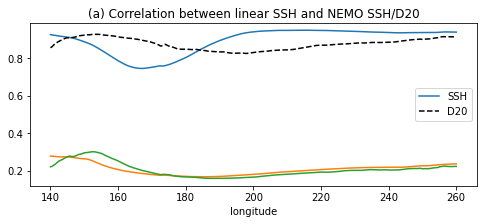

In [13]:
fig = plt.figure(figsize=(8,3))
corr_ssha_sshlia.plot(label='SSH')
corr_d20a_sshlia.plot(label='D20',color='black', linestyle='--')
corr_ssha_sshlia_up.plot()
corr_d20a_sshlia_up.plot()
plt.title('(a) Correlation between linear SSH and NEMO SSH/D20')
plt.xlabel('longitude');
plt.legend()

## Write output 

In [14]:
ds = xr.Dataset(
    dict(
        corr_ssha_sshlia=corr_ssha_sshlia,
        corr_d20a_sshlia=corr_d20a_sshlia,
        corr_ssha_sshlia_up=corr_ssha_sshlia_up,
        corr_d20a_sshlia_up=corr_d20a_sshlia_up,
        corr_ssha_sshlia_low=corr_ssha_sshlia_low,
        corr_d20a_sshlia_low=corr_d20a_sshlia_low,
        sshne=ssh_nemo,
        sshli=ssh_lin,
        d20ne=d20_nemo
    )
)

In [15]:
!rm -rf data_fig6.zarr
ds.to_zarr("data_fig6.zarr");